In [1]:
import os 
import pandas as pd
    
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import allel
import itertools
from matplotlib import gridspec
import matplotlib.pyplot as plt
import pickle
from statannot import add_stat_annotation
from scipy import stats
import matplotlib.cm as cm
import matplotlib

from math import pi
import scipy
import scipy.stats as st


pd.options.display.max_columns=200
pd.options.display.max_rows=100
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Important: 

The code to parse the raw somatic files across all Hartwig samples has been placed in the ../0_process_data/GIE_events/ folder. 

-- GIE events across Hartwig samples -> generated by the concat_reports_hmf.py script and copied into ../results/data/raw_data_gie_hmf.tsv

-- Immune infiltration across Hartwig samples -> generated by the concat_reports_infiltration_hmf.py and copied into ../results/data/raw_data_immune_hmf.tsv

In [3]:
path_escape="../results/data/raw_data_gie_hmf.tsv" # This is generated by the 
path_rna="../results/data/raw_data_immune_hmf.tsv" # change this with your path

In [4]:
def prepare_metadata():
    df_meta = pd.read_csv("../metadata/dataset_metadata_supp_table3.tsv",sep="\t")
    df_meta=df_meta[(df_meta["is_selected"]==True)]
    return df_meta[df_meta["cohort"]=="Hartwig"]
df = pd.read_csv(f"{path_escape}",sep="\t").rename(columns={"sample":"sample_id"})
df_metadata = prepare_metadata()
df=df.merge(df_metadata)
df_rna = pd.read_csv(f"{path_rna}",sep="\t")
df = df.merge(df_rna,how="left")
summary_cohort = pd.read_csv("../metadata/table_cancer_types_info.tsv",sep="\t") # Supp. Table 3

In [6]:
df.shape

(4439, 135)

### Define alterations to be considered

In [7]:
allowed_csq = set(["frameshift_variant","stop_gained","stop_lost","splice_acceptor_variant","splice_donor_variant","stop_gained","splice_region_variant","start_lost"]) # monoallelic
allowed_csq_biallelic = set(["missense_variant","structural_interaction_variant","conservative_inframe_deletion","conservative_inframe_insertion","disruptive_inframe_deletion","disruptive_inframe_insertion"]) # only biallelic 

alterations = pd.read_csv("../metadata/immune_selected_genes.tsv",sep="\t") # This is Supp. Table 1
alterations=alterations[alterations["Selected"]]

def app_pathway(row):
    selected_genes = alterations[alterations["Pathway_general"]=="Antigen Presentation Pathway"]["Gene"].values
    for gene in selected_genes:
        if (gene in str(row["del_scaffold_mhc"])) or (gene in str(row["del_tfs"])) or (gene in str(row["del_transport_mhc"])): 
            return pd.Series([True, f"del {gene}"])
        elif (is_clonally_mutated(gene,row["mut_scaffold_mhc"]) or (is_clonally_mutated(gene, row["mut_tfs"])) or (is_clonally_mutated(gene, row["mut_transport_mhc"]))):
            return pd.Series([True, f"mut {gene}"])
    return pd.Series([False,""])
            
def ifn_gamma_pathway(row):
    selected_genes=alterations[alterations["Pathway_general"]=="IFN-gamma pathway"]["Gene"].values
    for gene in selected_genes:
        if (gene in str(row["del_interferon"])): 
            return pd.Series([True, f"del {gene}"])
        elif (is_clonally_mutated(gene,row["mut_interferon"])):
            return pd.Series([True, f"mut {gene}"])
    return pd.Series([False,""])

def cd58_pathway(row):
    selected_genes=["CD58"]
    for gene in selected_genes:
        if (gene in str(row["del_cd58"])): 
            return pd.Series([True, f"del {gene}"])
        elif (is_clonally_mutated(gene,row["mut_cd58"])):
            return pd.Series([True, f"mut {gene}"])
    return pd.Series([False,""])

def checkpoint_pathway(row):
    genes = ["CD274"]
    for gene in genes:
        if gene in str(row["amps_inhibitors"]):
            return pd.Series([True,f"amp {gene}"])
    return pd.Series([False,""])

def epigenetic_regulators_pathway(row):
    genes = ["SETDB1"]
    for gene in genes:
        if gene in str(row["epigenetic_regulators"]):
            return pd.Series([True,f"amp {gene}"])
    return pd.Series([False,""])

def is_clonally_mutated(gene,muts):
    if not(";") in str(muts):
        return False
    muts_gene=0
    for mut in muts.split("___"):
       
        gene_mut,csq,allelic_status,germline_status,clonality_purple,clonality_timing,af,cn,macn=mut.split(";")
         
        if gene == gene_mut and (clonality_purple.startswith("clonal"))  and (len(set(csq.split("&")).intersection(allowed_csq))) >0: 
            return True # At least one clonal deleterios mutations
        if gene == gene_mut and (clonality_purple.startswith("clonal")) and allelic_status == "biallelic" and (len(set(csq.split("&")).intersection(allowed_csq_biallelic))) >0 :
            return True # At least one biallelic deleterios or non-synonymous likely impactful mutation (missense)
        if gene == gene_mut and (clonality_purple.startswith("clonal")) and allelic_status == "monoallelic" and (len(set(csq.split("&")).intersection(allowed_csq_biallelic))) >0:
            muts_gene+=1 # multiple non-synonymous monoallelic mutations
    return muts_gene>1 # multipl, at least two, non-synonymous monoallelic mutations

### Define type of alterations

In [8]:
df[["systemic_app_pathway","systemic_app_pathway_detail"]]  = df.apply(lambda row: app_pathway(row),axis=1)          
df[["cd58_pathway","cd58_pathway_detail"]]  = df.apply(lambda row: cd58_pathway(row),axis=1)          
df[["ifn_gamma_pathway","ifn_gamma_pathway_detail"]]  = df.apply(lambda row: ifn_gamma_pathway(row),axis=1)          
df[["checkpoint_pathway","checkpoint_pathway_detail"]]  = df.apply(lambda row: checkpoint_pathway(row),axis=1)
df[["epigenetic_regulators_pathway","epigenetic_regulators_pathway_detail"]]  = df.apply(lambda row: epigenetic_regulators_pathway(row),axis=1)
df["targeted_app_pathway_mut_HLA"] = df.apply(lambda row: row["mut_hla_lilac"],axis=1)
df["targeted_app_pathway_loh_HLA"] = df.apply(lambda row: row["loh_lilac"] ,axis=1)
df["targeted_app_pathway_del_HLA"] = df.apply(lambda row: (row["del_HLA-A"] == 1.) | (row["del_HLA-B"] == 1.) | (row["del_HLA-C"] == 1.) ,axis=1)
df["targeted_app_pathway_partdel_HLA"] = df.apply(lambda row: row["targeted_app_pathway_loh_HLA"] | row["targeted_app_pathway_del_HLA"] ,axis=1)
df["targeted_escape"] = df["targeted_app_pathway_mut_HLA"] | df["targeted_app_pathway_loh_HLA"] | df["targeted_app_pathway_del_HLA"]
df["non_targeted_escape"] = df["systemic_app_pathway"] | df["ifn_gamma_pathway"] | df["checkpoint_pathway"] | df["cd58_pathway"] | df["epigenetic_regulators_pathway"]
df["genetic_immune_escape"] = df["targeted_escape"] | df["non_targeted_escape"]

### Annotate type of LOH HLA (copy number neutral or dosage imbalance)

In [9]:
def get_copy_number_neutral_loh(row):
    if not(row["loh_lilac"]):
        return ""
    if "HLA" in str(row["loh_nonfocal"]):
        hlas= row["loh_nonfocal"].split(",")
    elif "HLA" in str(row["loh_focal"]):
        hlas= row["loh_focal"].split(",")
    else:
        hlas= row["loh_hfocal"].split(",")
    l=[]
    for hla in hlas:
        if row["ploidy_major_"+hla] >1:
            l.append(hla)
    return ",".join(l)
    


df["copy_number_neutral_loh_hla"] = df.apply(lambda row: get_copy_number_neutral_loh(row),axis=1)

In [10]:
df[df["loh_lilac"]==True]["copy_number_neutral_loh_hla"].value_counts()

HLA-A,HLA-C,HLA-B    592
                     174
HLA-C,HLA-B            9
HLA-A                  5
HLA-C                  2
HLA-B                  1
Name: copy_number_neutral_loh_hla, dtype: int64

In [11]:
df[(df["loh_lilac"]==True)&(df["loh_nonfocal"].str.contains("HLA",na=False))]["copy_number_neutral_loh_hla"].value_counts()

HLA-A,HLA-C,HLA-B    114
                      60
Name: copy_number_neutral_loh_hla, dtype: int64

In [12]:
114 / (60+114 )

0.6551724137931034

In [13]:
df[(df["loh_lilac"]==True)&(df["loh_focal"].str.contains("HLA",na=False))]["copy_number_neutral_loh_hla"].value_counts()

HLA-A,HLA-C,HLA-B    478
                     114
HLA-C,HLA-B            9
HLA-A                  5
HLA-C                  2
HLA-B                  1
Name: copy_number_neutral_loh_hla, dtype: int64

In [14]:
(478+9+5+2+1) / (478+9+5+2+1+114)

0.812807881773399

In [15]:
df[(df["loh_lilac"]==True)&(df["loh_hfocal"].str.contains("HLA",na=False))]["copy_number_neutral_loh_hla"].value_counts()

HLA-A,HLA-C,HLA-B    88
                     25
HLA-C,HLA-B           8
HLA-A                 4
HLA-C                 2
HLA-B                 1
Name: copy_number_neutral_loh_hla, dtype: int64

In [16]:
(88+8+4+2+1) / (88+8+4+2+1+25)

0.8046875

### Store the table with GIE events per Hartwig sample, this will be key part of Supp. Table 4

In [19]:
df.to_csv("../results/data/processed_hmf_escape_info.tsv.gz",sep="\t",compression="gzip",index=False)

In [20]:
df.shape

(4439, 153)

# Define global GIE prevalence metastatic setting

### First read metastatic

In [21]:
df = pd.read_csv("../results/data/processed_hmf_escape_info.tsv.gz",sep="\t")

/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (16,17,19,20,142) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Load ttypes selected

In [23]:
ttypes_selected=summary_cohort[summary_cohort["group_HMF"]]["cancer_type"].values

### Define pathways

In [24]:
features = ["targeted_app_pathway_mut_HLA","targeted_app_pathway_partdel_HLA","systemic_app_pathway","ifn_gamma_pathway","checkpoint_pathway","cd58_pathway","epigenetic_regulators_pathway","genetic_immune_escape"]
names = ["Somatic mutation HLA","LOH/partial del. HLA","Antigen presentation pathway","IFN-gamma pathway", "PD-L1 amplification","CD58 alteration","Epigenetic regulation by SETDB1","Genetic immune escape \n (GIE)"]

### Show variation across tumor types, only tumor types with sufficient representation

In [27]:
tmp=df[["targeted_app_pathway_mut_HLA","targeted_app_pathway_partdel_HLA"]].sum(axis=0)
tmp_norm = (tmp / df.shape[0])
tmp_norm
tmp_norm

targeted_app_pathway_mut_HLA        0.027484
targeted_app_pathway_partdel_HLA    0.176391
dtype: float64

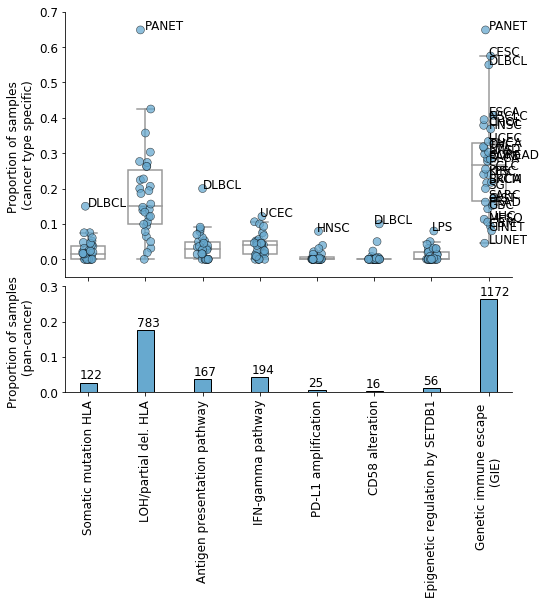

In [28]:
fig,ax=plt.subplots(figsize=(8,7))
pallete = {"wt":"#ef8a62","alteration":"#67a9cf","alteration_primary":"#7570b3"}
gs = gridspec.GridSpec(figure=fig, ncols=1, nrows=2, height_ratios=[5,2])
gs.update(hspace=0.05, wspace=0.0)
# distplot
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1],sharex=ax0)
'''
boxplot
'''
a=df[df["cancer_type"].isin(ttypes_selected)].groupby(["cancer_type_code"]).agg(dict([(feature,np.nanmean) for feature in features]+[("sample_id","count")])).reset_index()
a=a[a["sample_id"]>=15]
b=a[features+["cancer_type_code"]].melt(id_vars=["cancer_type_code"])
b=b.merge(a[["cancer_type_code","sample_id"]])
b["size"] = np.log2(b["sample_id"]+1)

g=sns.boxplot(data=b,x="variable",y="value",showfliers=False,color="white",linewidth=1.5,ax=ax0,width=0.6)

sns.stripplot(data=b,x="variable",y="value",alpha=0.75,color=pallete["alteration"],ax=ax0,linewidth=0.5,edgecolor="black",s=8)
ax0.set_ylabel("Proportion of samples \n(cancer type specific)",fontsize=12)
ax0.set_xlabel("")
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.set_xticks(range(0,len(features)))
# plot several examples
i=0
for k,v in dict(a[a["sample_id"]>=15].set_index("cancer_type_code").idxmax()).items():
    if k in features and k !="genetic_immune_escape":
        ax0.annotate(xy=(i,a[a["cancer_type_code"]==v][k]),s=v,fontsize=12)
        i+=1
for scode in a["cancer_type_code"].values:
    ax0.annotate(xy=(i,a[a["cancer_type_code"]==scode]["genetic_immune_escape"]),s=scode,fontsize=12)
ax0.set_xticklabels([])
ax0.tick_params(axis='both', which='major', labelsize=12)
ax0.set_ylim(-0.05,0.7)
'''
barplot
'''
tmp = df[features].sum(axis=0)
tmp_norm = (tmp / df.shape[0])
tmp_norm.plot(kind="bar",ylim=(0,0.6),ax=ax1,color=pallete["alteration"],edgecolor="black",width=0.3)
N=df.shape[0]

for i,n in enumerate(tmp_norm.index):
    ax1.annotate(xy=(i-0.15,tmp_norm[i]+0.01),s=int(N*tmp_norm[i]),fontsize=12)
ax1.set_ylabel("Proportion of samples \n (pan-cancer)",fontsize=12)
ax1.set_xticklabels(names,fontsize=12)
ax1.set_ylim(0,0.3)
ax1.tick_params(axis='both', which='major', labelsize=12)


_=ax1.set_xticklabels(names,rotation=90,fontsize=12)

ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

plt.savefig(f'../results/figures/figure2/boxplot_ttype_frequency_selected_hmf.pdf', dpi=800,bbox_inches="tight")

In [29]:
a["genetic_immune_escape"].describe()

count    30.000000
mean      0.272389
std       0.145530
min       0.045455
25%       0.164292
50%       0.266179
75%       0.329545
max       0.648649
Name: genetic_immune_escape, dtype: float64

In [30]:
tmp_norm

targeted_app_pathway_mut_HLA        0.027484
targeted_app_pathway_partdel_HLA    0.176391
systemic_app_pathway                0.037621
ifn_gamma_pathway                   0.043704
checkpoint_pathway                  0.005632
cd58_pathway                        0.003604
epigenetic_regulators_pathway       0.012615
genetic_immune_escape               0.264023
dtype: float64

In [31]:
tmp_norm

targeted_app_pathway_mut_HLA        0.027484
targeted_app_pathway_partdel_HLA    0.176391
systemic_app_pathway                0.037621
ifn_gamma_pathway                   0.043704
checkpoint_pathway                  0.005632
cd58_pathway                        0.003604
epigenetic_regulators_pathway       0.012615
genetic_immune_escape               0.264023
dtype: float64

In [47]:
4439*0.003604

15.998156

In [45]:
df[df["genetic_immune_escape"]==True].shape[0] / df.shape[0]

0.2640234287001577

### Save a cancer-type summary of GIE events grouped by pathway per cancer type in Hartwig (Supp. Table 4)

In [32]:
a.sort_values("genetic_immune_escape",ascending=False).rename(columns={"sample_id":"n_samples"}).merge(df[["cancer_type_code","cancer_type"]].drop_duplicates()).to_csv("../results/data/summary_gie_cancer_type_hartwig.tsv",sep="\t",index=False)

### Prepare a table with GIE events per gene, not only grouped by pathway (Supp. Table 4)

In [ ]:
def ratio(grp):
    total = len(grp)
    return sum(grp) / total
d_counts_ttype=df.groupby(["cancer_type_code"]).agg({"sample_id":"count"}).to_dict()["sample_id"]

In [34]:
cs=['systemic_app_pathway_detail',        'cd58_pathway_detail',        'ifn_gamma_pathway_detail',       'checkpoint_pathway_detail',        'epigenetic_regulators_pathway_detail',       'targeted_app_pathway_mut_HLA', 'targeted_app_pathway_loh_HLA',       'targeted_app_pathway_del_HLA']
l_rs=[]
for c in cs:
    tmp=df[df[c.replace("_detail","")]==True]

    tmp["value"]=True
    tmp=tmp.pivot_table(index=["sample_id","cancer_type_code"],columns=[c],values=["value"],fill_value=False)
    values=[x[1] for x in tmp.columns.values]
    tmp.columns=values
    tmp=tmp.reset_index().groupby("cancer_type_code").agg(dict([(feature,np.nansum) for feature in values]))
    tmp["total_samples"] = tmp.apply(lambda row: d_counts_ttype[row.name],axis=1)
    if not("detail" in c):
        tmp.rename(columns={True:c},inplace=True)
    tmp = tmp.astype(float)
    if not("detail" in c):
        tmpn=pd.DataFrame((tmp[c].div(tmp["total_samples"],axis=0))*100.0,columns=["_".join(c.split("_")[-2:])])
    else:
        tmpn=(tmp[values].div(tmp["total_samples"],axis=0))*100.0
    l_rs.append(tmpn)

stats_gene=pd.concat(l_rs,axis=1).fillna(0.0).reset_index().rename(columns={"index":"cancer_type_code"}).merge(df[["cancer_type_code","cancer_type"]].drop_duplicates())
stats_gene["total_samples"] = stats_gene.apply(lambda row: d_counts_ttype[row.cancer_type_code],axis=1)
stats_gene.to_csv("../results/data/summary_gie_per_gene_cancer_type_hartwig.tsv",sep="\t",index=False) # Supp. Table 4

### Going more specific into type of alterations per tumor type (radar plots)

In [ ]:
ttype_general=df.groupby(["cancer_type"],as_index=False).agg({"epigenetic_regulators_pathway":ratio,"cd58_pathway":ratio,"systemic_app_pathway":ratio,"targeted_app_pathway_mut_HLA":ratio,"targeted_app_pathway_partdel_HLA":ratio,"ifn_gamma_pathway":ratio,"checkpoint_pathway":ratio,"genetic_immune_escape":ratio,"sample_id":"count"}).rename(columns={"sample_id":"n_samples"})
order=list(ttype_general[ttype_general["n_samples"]>=15].sort_values("genetic_immune_escape",ascending=False)["cancer_type"])
ratio_met=ttype_general.sort_values("genetic_immune_escape",ascending=False).set_index("cancer_type")
ratio_met=ratio_met.loc[order]

In [37]:
name_features = {"epigenetic_regulators_pathway":"Epigenetic regulation SETDB1","systemic_app_pathway":"Antigen Presentation Pathway","targeted_app_pathway_mut_HLA":"Mutation HLA genes","targeted_app_pathway_partdel_HLA":"LOH/partial del. HLA","ifn_gamma_pathway": "Alteration Interferon gamma", "checkpoint_pathway":"Checkpoint amplification","cd58_pathway":"CD58 alteration"}
def plot_radar_ttype(values,label,features = features,path_output="results/test.svg",ttype=""):
    # Definition of variables 
    fig,ax = plt.subplots(figsize=(5.,5.))
    fig.suptitle(label,fontsize=18)
    categories=features
    N = len(categories)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    values +=  values[:1]
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    ax.spines['polar'].set_visible(False)
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.vlines(angles[:-1], 0, [3 for x in range(len(angles[:-1]))], colors="#DCDCDC", zorder=3,linewidth=1.5,alpha=0.5) 
    # Draw ylabels
    ax.set_rlabel_position(0)
    maxv = np.nanmax(values)
    minv = 0.0
    plt.yticks(np.arange(minv,maxv+0.99,0.1), np.arange(minv,maxv+0.99,0.1), color="black", size=10)
    
    ax.plot(angles, values, linewidth=3.5, linestyle='solid', label="Muts",color=pallete["alteration"])
    ax.fill_between(angles, values, linewidth=0.5, linestyle='solid', label="Muts",color=pallete["alteration"],alpha=0.25)
    #ax.grid(b=None,axis="x")
    ax.grid(axis="y",lw=1.25)
    ax.set_yticklabels([ f"{v:.1f}" for v in ax.get_yticks()])
    plt.ylim(minv,maxv+0.1)
    
    # Draw one axe per variable + add labels labels yet
    _=plt.xticks(angles[:-1], [name_features[x]  for x in features],fontsize=12)
    path_output=f"../results/figures/figure2/{ttype.replace(' ','_')}_met_radar.pdf"
    plt.savefig(path_output,dpi=800,bbox_inches="tight")

### What type of alterations per ttype

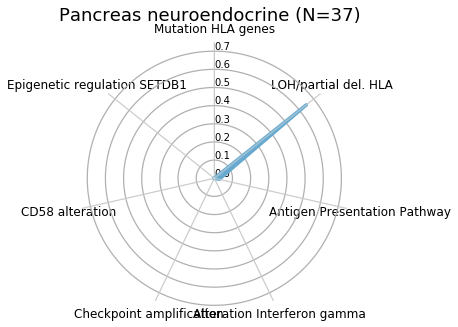

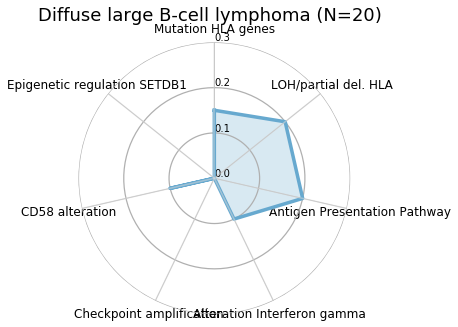

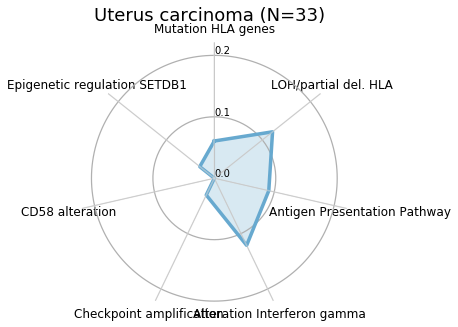

In [38]:
for ttype in ratio_met.loc[["Pancreas neuroendocrine","Diffuse large B-cell lymphoma","Uterus carcinoma"]].index:
    plot_radar_ttype(list(ratio_met.loc[ttype][features[:-1]].values),features=features[:-1],label=ttype+f" (N={int(ratio_met.loc[ttype]['n_samples'])})",ttype=ttype)
    

## Analysis of mutual exclusivity



In [ ]:
order=list(ttype_general[ttype_general["n_samples"]>=15].sort_values("genetic_immune_escape",ascending=False)["cancer_type"])

##### LOH of HLA-I vs non-targeted (using Fishers' exact test)

In [79]:
l=[]
for ttype in order:
    tmp=df[df["cancer_type"]==ttype]
    total=tmp.shape[0]
    a=tmp[(tmp["loh_lilac"]==True)&(tmp["non_targeted_escape"])].shape[0]
    b=tmp[(tmp["loh_lilac"])&(~tmp["non_targeted_escape"])].shape[0]
    if (a+b) < 15:
        continue
    c=tmp[(~tmp["loh_lilac"])&(tmp["non_targeted_escape"])].shape[0]
    d=tmp[(~tmp["loh_lilac"])&(~tmp["non_targeted_escape"])].shape[0]
    o,p=st.fisher_exact([[a,b],[c,d]],alternative="less")
    l.append([ttype,p,o,a,b,c,d])
df_stats_me=pd.DataFrame(l,columns=["cancer_type","pvalue_fisher","odds_ratio","loh_and_other_gie","loh_not_other_gie","not_loh_and_other_gie","not_loh_not_other_gie"]).sort_values("pvalue_fisher")
df_stats_me

,cancer_type,pvalue_fisher,odds_ratio,loh_and_other_gie,loh_not_other_gie,not_loh_and_other_gie,not_loh_not_other_gie
5,Ovarian cancer,0.085566,0.209259,1,36,15,113
14,Prostate carcinoma,0.122554,0.000000,0,20,39,342
12,CUP,0.521386,0.000000,0,16,4,88
6,Colorectum carcinoma,0.674741,1.092045,11,117,39,453
7,Pancreas carcinoma,0.737374,0.000000,0,26,1,72
1,Cervix carcinoma,0.802823,1.428571,3,14,3,20
3,Non small cell lung cancer,0.823992,1.248606,21,117,46,320
11,Breast cancer,0.829720,1.302464,11,98,53,615
2,Esophagus cancer,0.892127,1.869565,4,46,4,86
9,Kidney clear cell carcinoma,0.913453,2.173913,2,23,4,100


##### LOH of HLA-I vs non-targeted (using a randomization, part of Supp. Table 4)

In [80]:
rs=[]
for ttype in order:
    tmp=df[df["cancer_type"]==ttype]
    a=tmp[(tmp["loh_lilac"]==True)&(tmp["non_targeted_escape"])].shape[0]
    b=tmp[(tmp["loh_lilac"])&(~tmp["non_targeted_escape"])].shape[0]
    if (a+b) < 15:
        continue
    
    pa=tmp[tmp["loh_lilac"]].shape[0]/tmp.shape[0]
    pb=tmp[(tmp["non_targeted_escape"])].shape[0]/tmp.shape[0]
    counts=tmp[(tmp["loh_lilac"])&((tmp["non_targeted_escape"]))].shape[0] 
    l_data=[]
    N=10000
    for _ in range(N):
        ma=np.random.binomial(1,p=pa,size=tmp.shape[0])
        mb=np.random.binomial(1,p=pb,size=tmp.shape[0])
        overlap=np.nansum(ma&mb)
        l_data.append(overlap)
    pvalue=np.nansum(counts >= np.array(l_data)) / 10000
    rs.append([ttype,pvalue,counts,np.nanmean(l_data)])
simulated_me=pd.DataFrame(rs,columns=["cancer_type","pvalue_simulations","observed_overlap","expected_mean_overlap"]).sort_values("pvalue_simulations")
simulated_me.merge(df_stats_me)[["cancer_type","loh_and_other_gie","loh_not_other_gie","not_loh_and_other_gie","not_loh_not_other_gie","odds_ratio","pvalue_fisher","expected_mean_overlap","pvalue_simulations"]].to_csv("../results/data/mutual_exclusivity_hartwig.tsv",sep="\t",index=False)
simulated_me.merge(df_stats_me)[["cancer_type","loh_and_other_gie","loh_not_other_gie","not_loh_and_other_gie","not_loh_not_other_gie","odds_ratio","pvalue_fisher","expected_mean_overlap","pvalue_simulations"]]
    

    
    

,cancer_type,loh_and_other_gie,loh_not_other_gie,not_loh_and_other_gie,not_loh_not_other_gie,odds_ratio,pvalue_fisher,expected_mean_overlap,pvalue_simulations
0,Ovarian cancer,1,36,15,113,0.209259,0.085566,3.5940,0.1225
1,Prostate carcinoma,0,20,39,342,0.000000,0.122554,1.9592,0.1397
2,CUP,0,16,4,88,0.000000,0.521386,0.6173,0.5438
3,Colorectum carcinoma,11,117,39,453,1.092045,0.674741,10.2912,0.6612
4,Cervix carcinoma,3,14,3,20,1.428571,0.802823,2.5422,0.7544
5,Pancreas carcinoma,0,26,1,72,0.000000,0.737374,0.2559,0.7743
6,Non small cell lung cancer,21,117,46,320,1.248606,0.823992,18.3057,0.7823
7,Breast cancer,11,98,53,615,1.302464,0.829720,9.0174,0.8000
8,Esophagus cancer,4,46,4,86,1.869565,0.892127,2.8647,0.8374
9,Pancreas neuroendocrine,1,23,0,13,inf,1.000000,0.6453,0.8646
